# Analyze data for ASA189
This script analyzes the acoustic correlates of stop and nasal geminates in Dunan

In [68]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from scipy.stats import ttest_ind, pearsonr

sns.set(font_scale = 1.75, style = 'ticks', palette = 'tab10')

In [2]:
# Factors and how we want to label them
fac_to_title = {'strF0':'f0 (Hz)', 'pF1':'F1 (Hz)', 'pF2':'F2 (Hz)', 'H1H2c': 'H1* - H2* (dB)', 
                'H1A1c': 'H1* - A1* (dB)', 'H1A2c': 'H1* - A2* (dB)', 'H1A3c': 'H1* - A3* (dB)',
                'CPP': 'CPP (dB)', 'Energy': 'RMS Energy'}

In [4]:
# Read in output (make sure it is unzipped)
df = pd.read_csv('../data/stop_output.txt', sep = '\t')

# Split filename into sp, word, round, order
df['ms'] = df['t_ms'] - np.round(df['seg_Start'])

#
df_v = df.query('Label in ["a", "i", "u"]') # e, o

In [7]:
# Merge with original
df_info = pd.read_csv('../data/stop_targets.csv')

# Change name
df_info['Filename'] = df_info['fname'].apply(lambda f: f.replace('/aligned/', '\\').replace('TextGrid', 'mat'))

# Change time to seconds
df_info['seg_Start'] = df_info['vowel_start'] * 1000
#df_info['seg_End'] = df_info['next_phon_end'] * 1000

df_analyze = df_v.merge(df_info, on = ['Filename', 'seg_Start'])

df_analyze['time'] = df_analyze.groupby(['Filename', 'seg_Start'])['t_ms'].apply(pd.cut, bins = 20, labels = False) + 1

measures = [m for m in fac_to_title.keys()]

keep = ['Filename', 'Label', 'word', 'seg_Start', 'seg_End', 'c_quality', 'geminate', 'time']

df_analyze_kt = df_analyze.query('c_quality in ["k", "t"]')

df_stop_timenorm = df_analyze_kt.groupby(keep)[measures].mean().reset_index()

In [8]:
df_info.query('c_quality in ["k", "t"]').groupby(['c_quality', 'next_phon']).geminate.value_counts()

c_quality  next_phon  geminate
k          AA1        no          582
                      yes          86
           IY1        no          430
                      yes           7
           OW1        no           16
           UW1        no          318
                      yes          50
           W          yes           1
           Y          no           44
t          AA1        no          170
                      yes         109
           EY1        no            1
           IY1        no           79
                      yes          25
           OW1        no            2
           UW1        yes         422
                      no          415
Name: geminate, dtype: int64

In [9]:
df_info.query('(c_quality in ["k", "t"])').next_phon.value_counts()

UW1    1205
AA1     947
IY1     541
Y        44
OW1      18
EY1       1
W         1
Name: next_phon, dtype: int64

In [10]:
df_info.query('(c_quality in ["k", "t"]) & (next_phon not in ["Y", "W"])').next_phon.value_counts()

UW1    1205
AA1     947
IY1     541
OW1      18
EY1       1
Name: next_phon, dtype: int64

In [22]:
stops_exist = pd.read_csv('../data/stop_duration_nooutliers.csv')#.query('burst_time != -1')

stops_exist['closdur'] = stops_exist['burst_time'] - stops_exist['new_start']

print(len(stops_exist.query('c_quality not in ["c", "ts", "p"]')))

1414


# Clean up data for analysis

In [13]:
df_full = df_info.query('(c_quality in ["k", "t"]) & (next_phon not in ["W", "Y", "EY1"])').reset_index(drop = True)

df_full['vowel_end'] = df_full['next_phon_end']
df_full['vowel'] = df_full['next_phon']

df_full['vdur'] = df_full['vowel_end'] - df_full['vowel_start']

df_full['Filename'] = df_full['Filename'].str.replace('.mat', '.wav', regex = False).str.replace('\\', '/', regex = False)

df_full = df_full[['Filename', 'onset', 'label', 'c_quality', 'geminate', 'vowel',
                   'closure_start', 'VOT_start', 'vowel_start', 'vowel_end', 'vdur',
                   'word', 'sentence', 'prev_phon', 'prev_phon_start', 'prev_phon_end', 'vot_exists']]

In [15]:
df_full.to_csv('../data/df_full.csv')

df_vot = df_full.query('vot_exists == "yes"').reset_index(drop = True)

df_vot['votdur'] = df_vot['vowel_start'] - df_vot['VOT_start']

df_vot.to_csv('../data/df_vot.csv')

In [17]:
df_closdur = pd.read_csv('../data/stop_duration_nooutliers.csv').query('(c_quality in ["k", "t"]) & (next_phon not in ["W", "Y", "EY1"]) & (burst_time != -1)').reset_index(drop = True)

df_closdur['Filename'] = df_closdur['fname'].str.replace('aligned/', '', regex = False).str.replace('.TextGrid', '.wav', regex = False)

df_closdur['closure_start'] = df_closdur['new_start']
df_closdur['VOT_start'] = df_closdur['burst_time']
df_closdur['vowel_start'] = df_closdur['next_phon_start']
df_closdur['vowel_end'] = df_closdur['next_phon_end']
df_closdur['vowel'] = df_closdur['next_phon']

df_closdur['closdur'] = df_closdur['VOT_start'] - df_closdur['closure_start']
df_closdur['cdur'] = df_closdur['vowel_start'] - df_closdur['closure_start']
df_closdur['votdur'] = df_closdur['vowel_start'] - df_closdur['VOT_start']
df_closdur['vdur'] = df_closdur['vowel_end'] - df_closdur['vowel_start']

df_closdur = df_closdur[['Filename', 'onset', 'label', 'c_quality', 'geminate', 'vowel',
                   'closure_start', 'VOT_start', 'vowel_start', 'vowel_end', 
                   'closdur', 'votdur', 'cdur', 'vdur',
                   'word', 'sentence', 'prev_phon', 'prev_phon_start', 'prev_phon_end']]

df_closdur.to_csv('../data/df_closdur.csv')

In [18]:
for df in [df_full, df_vot, df_closdur]:
    print(len(df))

2711
2405
1225


In [19]:
# All
df_vdur = df_info.query('(c_quality in ["k", "t"]) & (next_phon not in ["Y", "W"])').reset_index(drop = True)

df_vdur['vdur'] = df_vdur['next_phon_end'] - df_vdur['vowel_start']

Ttest_indResult(statistic=-16.461985956567972, pvalue=4.149869492592475e-58)

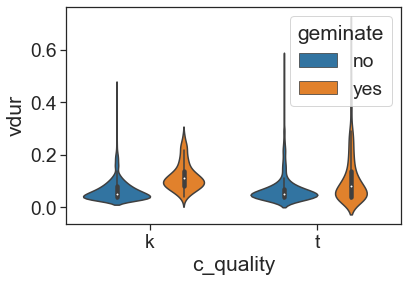

In [23]:
# Violin plots for singletons vs. geminates for vowels following k and t
sns.violinplot(data = df_vdur, x = 'c_quality', y = 'vdur', hue = 'geminate')

plt.savefig('../visual/vowel_duration-geminate.png', dpi = 300, transparent = True, bbox_inches = 'tight')

ttest_ind(df_vdur.query('geminate == "no"')['vdur'], df_vdur.query('geminate == "yes"')['vdur'])

In [24]:
df_closdur['Duration (ms)'] = df_closdur['closdur'] * 1000
df_closdur['VOT (ms)'] = df_closdur['votdur'] * 1000
df_closdur['Geminate'] = df_closdur['geminate']

df_closdur['dummy'] = 0


Ttest_indResult(statistic=-12.63163192633095, pvalue=1.810189897950345e-34)
80.26350759345794
107.89566395663957


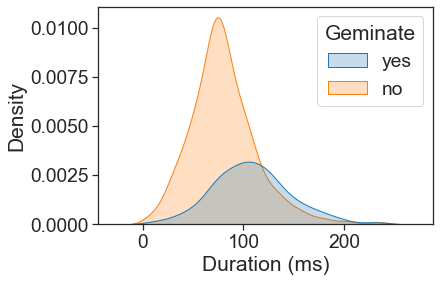

In [27]:
sns.kdeplot(data = df_closdur, x = 'Duration (ms)', hue = 'Geminate', hue_order = ['yes', 'no'], fill = True)

plt.savefig('../visual/dunan_duration.png', dpi = 300, transparent = True, bbox_inches = 'tight')

print(ttest_ind(df_closdur.query('geminate == "no"')['Duration (ms)'], df_closdur.query('geminate == "yes"')['Duration (ms)']))

print(df_closdur.query('geminate == "no"')['Duration (ms)'].mean())
print(df_closdur.query('geminate == "yes"')['Duration (ms)'].mean())

Ttest_indResult(statistic=22.790632450827612, pvalue=4.1449250081799215e-96)
52.364997079439256
15.546070460704595


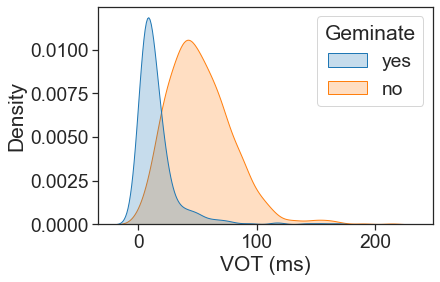

In [30]:
sns.kdeplot(data = df_closdur, x = 'VOT (ms)', hue = 'Geminate', hue_order = ['yes', 'no'], fill = True)

plt.savefig('/Users/Raksit/Desktop/dunan_vot.png', dpi = 300, transparent = True, bbox_inches = 'tight')

print(ttest_ind(df_closdur.query('geminate == "no"')['VOT (ms)'], df_closdur.query('geminate == "yes"')['VOT (ms)']))

print(df_closdur.query('geminate == "no"')['VOT (ms)'].mean())
print(df_closdur.query('geminate == "yes"')['VOT (ms)'].mean())


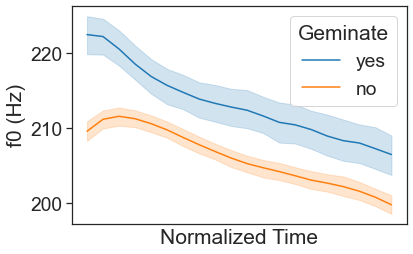

In [31]:
sns.lineplot(data = df_stop_timenorm, x = 'time', y = 'strF0', hue = 'geminate', hue_order = ['yes', 'no'])

plt.gca().axes.xaxis.set_ticks([])
plt.xlabel('Normalized Time')
plt.ylabel('f0 (Hz)')

plt.gca().axes.legend(title = 'Geminate')

plt.savefig('../visual/dunan_f0.png', dpi = 300, transparent = True, bbox_inches = 'tight')

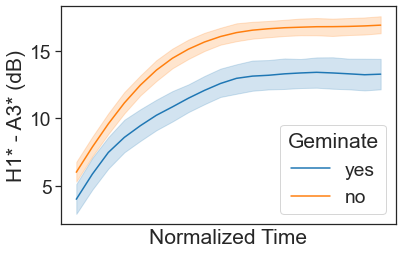

In [32]:
sns.lineplot(data = df_stop_timenorm, x = 'time', y = 'H1A3c', hue = 'geminate', hue_order = ['yes', 'no'])

plt.gca().axes.xaxis.set_ticks([])
plt.xlabel('Normalized Time')
plt.ylabel('H1* - A3* (dB)')

plt.gca().axes.legend(title = 'Geminate')

plt.savefig('../visual/dunan_H1A3.png', dpi = 300, transparent = True, bbox_inches = 'tight')

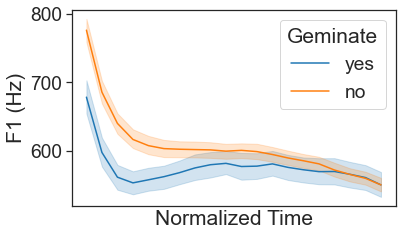

In [33]:
sns.lineplot(data = df_stop_timenorm, x = 'time', y = 'pF1', hue = 'geminate', hue_order = ['yes', 'no'])

plt.gca().axes.xaxis.set_ticks([])
plt.xlabel('Normalized Time')
plt.ylabel('F1 (Hz)')

plt.gca().axes.legend(title = 'Geminate')

plt.subplots_adjust(left = 0.15, bottom = 0.20)

plt.savefig('../visual/dunan_H1A3.png', dpi = 300, transparent = True, bbox_inches = 'tight')

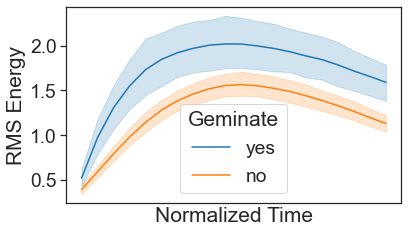

In [34]:
sns.lineplot(data = df_stop_timenorm, x = 'time', y = 'Energy', hue = 'geminate', hue_order = ['yes', 'no'])

plt.gca().axes.xaxis.set_ticks([])
plt.xlabel('Normalized Time')
plt.ylabel('RMS Energy')

plt.gca().axes.legend(title = 'Geminate')

plt.subplots_adjust(bottom = 0.20)

plt.savefig('../visual/dunan_RMS.png', dpi = 300, transparent = True, bbox_inches = 'tight')

In [35]:
# All
df_info.query('c_quality in ["k", "t"]').groupby(['c_quality']).geminate.value_counts()

# Detectable stop duration
pd.read_csv('../data/stop_duration_nooutliers.csv').query('c_quality in ["k", "t"]').groupby(['c_quality']).geminate.value_counts()

c_quality  geminate
k          no          672
           yes          64
t          yes         340
           no          338
Name: geminate, dtype: int64

In [36]:
df_info.query('(c_quality in ["k", "t"]) & (next_phon in ["AA1", "IY1", "UW1"])').groupby('c_quality').geminate.value_counts()

c_quality  geminate
k          no          1330
           yes          143
t          no           664
           yes          556
Name: geminate, dtype: int64

# Plots for poster

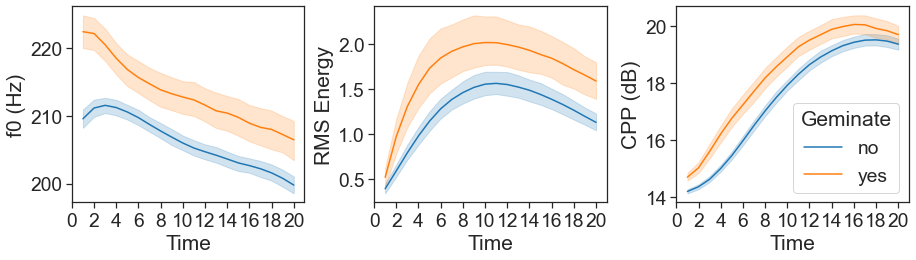

In [41]:
fig, axs = plt.subplots(1, 3, figsize = (15, 4))

for i, fac in enumerate(['strF0', 'Energy', 'CPP']):
    
    ax = axs.flat[i]

    sns.lineplot(data = df_stop_timenorm, x = 'time', y = fac, hue = 'geminate', ax = ax)

    ax.set(xticks = np.arange(0, 21, 2), xlabel = 'Time', ylabel = fac_to_title[fac])

    if i != 2: 
        ax.get_legend().remove()
    else:
        ax.legend(title = 'Geminate')

plt.subplots_adjust(wspace = 0.3, bottom=0.2)

plt.savefig('../visual/poster/stop_row2.png', dpi = 300, transparent = True)

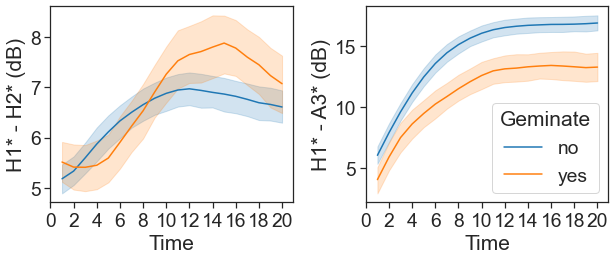

In [42]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4))

for i, fac in enumerate(['H1H2c', 'H1A3c']):
    
    ax = axs.flat[i]

    sns.lineplot(data = df_stop_timenorm, x = 'time', y = fac, hue = 'geminate', ax = ax)

    ax.set(xticks = np.arange(0, 21, 2), xlabel = 'Time', ylabel = fac_to_title[fac])

    if i != 1: 
        ax.get_legend().remove()
    else:
        ax.legend(title = 'Geminate')

plt.subplots_adjust(wspace = 0.3, bottom=0.2)

plt.savefig('../visual/poster/stop_row3.png', dpi = 300, transparent = True)

In [43]:
df_stop_timenorm['Vowel Duration'] = df_stop_timenorm['seg_End'] - df_stop_timenorm['seg_Start']

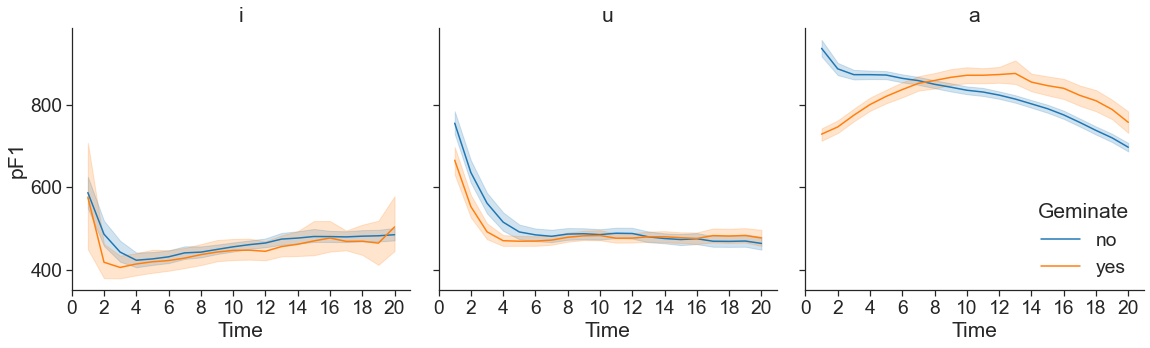

In [47]:
g = sns.relplot(data = df_stop_timenorm, x = 'time', y = 'pF1', hue = 'geminate', kind = 'line', col = 'Label', col_order = ['i', 'u', 'a'])

for ax, c in zip(g.axes.flat, ['i', 'u', 'a']):

    ax.set_xticks(np.arange(0, 21, 2))
    ax.set_xlabel('Time')
    ax.set_title(c)

plt.ylabel('F1 (Hz)')

g._legend.set(title = 'Geminate', bbox_to_anchor = (0.97, 0.3))

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)

plt.savefig('../visual/poster/stop_F1-byvowel.png', dpi = 300, transparent = True)

# Nasals

In [60]:
df_nas_acoustic = pd.read_csv('../data/nasal_output.txt', sep = '\t')

df_nas_acoustic = df_nas_acoustic[[c for c in df_nas_acoustic if "Unnamed" not in c]]

# Split filename into sp, word, round, order
df_nas_acoustic['ms'] = df_nas_acoustic['t_ms'] - np.round(df_nas_acoustic['seg_Start'])

#
df_nas_v = df_nas_acoustic.query('Label in ["a", "i", "u"]')

# Change name
df_nas_info = pd.read_csv('../data/nasal_targets.csv')
df_nas_info = df_nas_info[[c for c in df_nas_info if 'Unnamed: ' not in c]]

df_nas_info['duration'] = (df_nas_info['phon_end'] - df_nas_info['phon_start'])*1000
df_nas_info['Filename'] = df_nas_info['fname'].apply(lambda f: f.replace('/aligned/', '\\').replace('TextGrid', 'mat'))

# Change time to seconds
df_nas_info['seg_Start'] = df_nas_info['next_phon_start'] * 1000
df_info['seg_End'] = df_info['next_phon_end'] * 1000

df_analyze_nas = df_nas_v.merge(df_nas_info, on = ['Filename', 'seg_Start'])

df_analyze_nas['time'] = df_analyze_nas.groupby(['Filename', 'seg_Start'])['t_ms'].apply(pd.cut, bins = 20, labels = False) + 1

measures = [m for m in fac_to_title.keys()]

keep = ['Filename', 'Label', 'word', 'seg_Start', 'seg_End', 'c_quality', 'geminate', 'time']

df_nas_timenorm = df_analyze_nas.groupby(keep)[measures].mean().reset_index()

In [61]:
df_nas_timenorm.Label.value_counts()

a    18560
u    12960
i     9180
Name: Label, dtype: int64

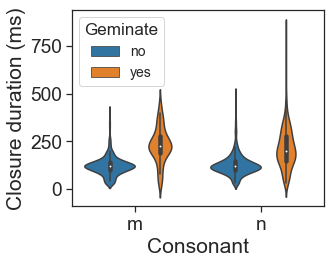

In [62]:
plt.subplots(1, 1, figsize = (5, 4))

g = sns.violinplot(data = df_nas_info.query('next_phon in ["AA1", "IY1", "UW1"]'), x = 'c_quality', y = 'duration', hue = 'geminate')

plt.xlabel('Consonant')
#plt.yticks(np.arange(0, 300, 50))
plt.ylabel('Closure duration (ms)')
plt.legend(title = 'Geminate', loc = 'upper left', fontsize = 14, title_fontsize = 17)

plt.subplots_adjust(left = 0.2, bottom = 0.2)

plt.savefig('../visual/poster/nas_row1.png', dpi = 300, transparent = True)

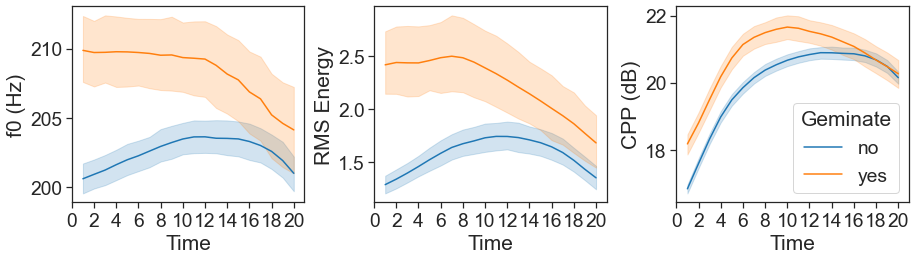

In [54]:
fig, axs = plt.subplots(1, 3, figsize = (15, 4))

for i, fac in enumerate(['strF0', 'Energy', 'CPP']):
    
    ax = axs.flat[i]

    sns.lineplot(data = df_nas_timenorm, x = 'time', y = fac, hue = 'geminate', hue_order = ['no', 'yes'], ax = ax)

    ax.set(xticks = np.arange(0, 21, 2), xlabel = 'Time', ylabel = fac_to_title[fac])

    if i != 2: 
        ax.get_legend().remove()
    else:
        ax.legend(title = 'Geminate')

plt.subplots_adjust(wspace = 0.3, bottom=0.2)

plt.savefig('../visual/poster/nas_row2.png', dpi = 300, transparent = True)

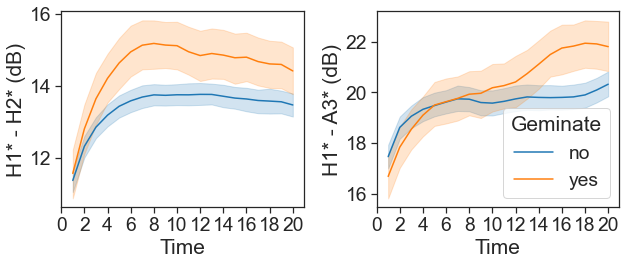

In [55]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4))

for i, fac in enumerate(['H1H2c', 'H1A3c']):
    
    ax = axs.flat[i]

    sns.lineplot(data = df_nas_timenorm, x = 'time', y = fac, hue = 'geminate', hue_order = ['no', 'yes'], ax = ax)

    ax.set(xticks = np.arange(0, 21, 2), xlabel = 'Time', ylabel = fac_to_title[fac])

    if i != 1: 
        ax.get_legend().remove()
    else:
        ax.legend(title = 'Geminate')

plt.subplots_adjust(wspace = 0.3, bottom=0.2)

plt.savefig('../visual/poster/nas_row3.png', dpi = 300, transparent = True)

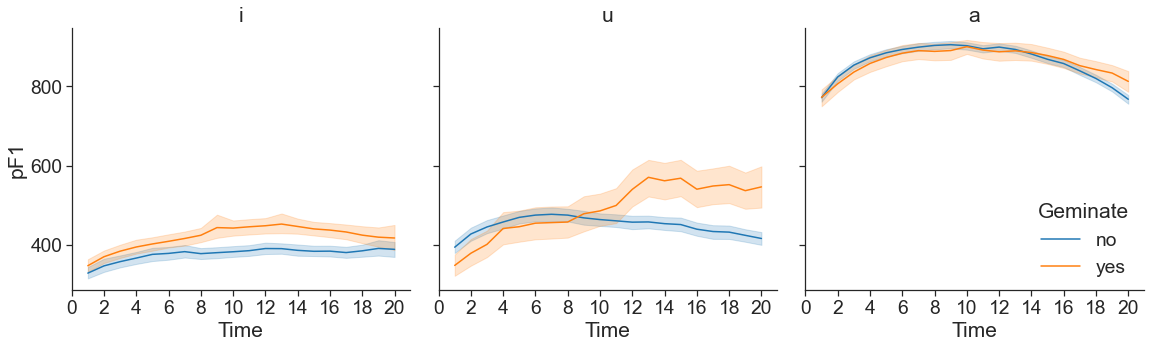

In [56]:
g = sns.relplot(data = df_nas_timenorm.query('Label in ["u", "a", "i"]'), x = 'time', y = 'pF1', hue = 'geminate', hue_order = ['no', 'yes'],
                kind = 'line', col = 'Label', col_order = ['i', 'u', 'a'])

for ax, c in zip(g.axes.flat, ['i', 'u', 'a']):

    ax.set_xticks(np.arange(0, 21, 2))
    ax.set_xlabel('Time')
    ax.set_title(c)

plt.ylabel('F1 (Hz)')

g._legend.set(title = 'Geminate', bbox_to_anchor = (0.97, 0.3))

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)

plt.savefig('../visual/poster/nas_F1-byvowel.png', dpi = 300, transparent = True)

In [232]:
df_info.query('c_quality in ["k", "t"]').groupby(['next_phon'])['geminate'].value_counts()

next_phon  geminate
AA1        no          752
           yes         195
EY1        no            1
IY1        no          509
           yes          32
OW1        no           18
UW1        no          733
           yes         472
W          yes           1
Y          no           44
Name: geminate, dtype: int64

# Split up stops

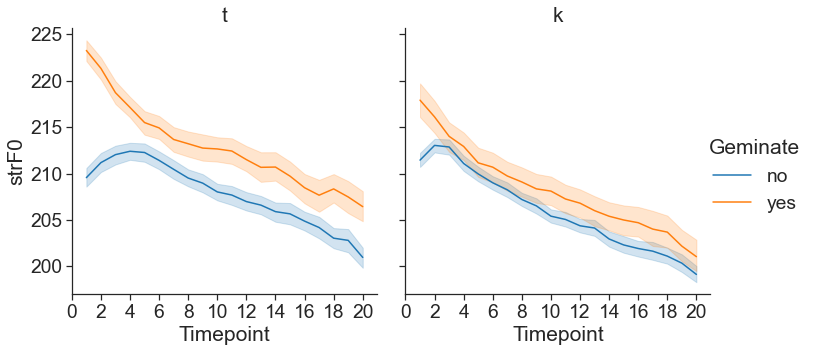

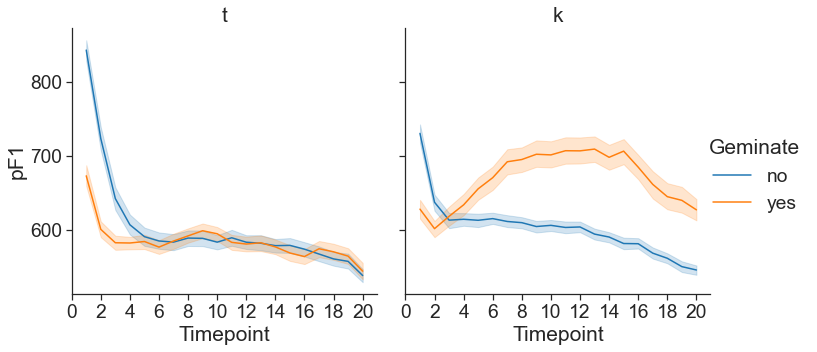

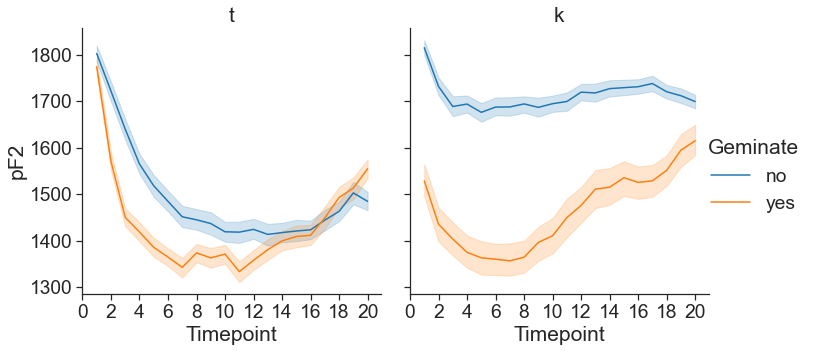

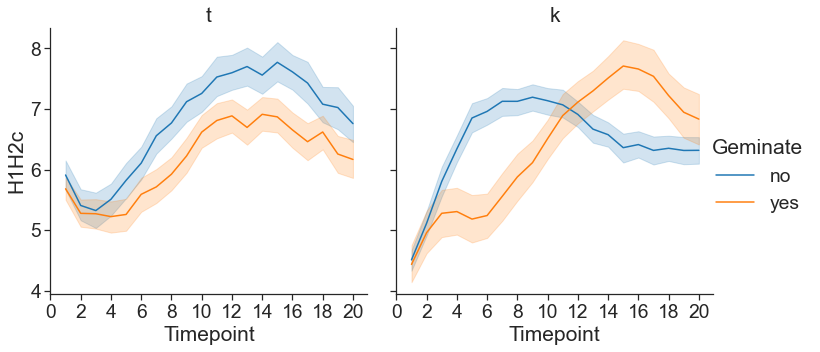

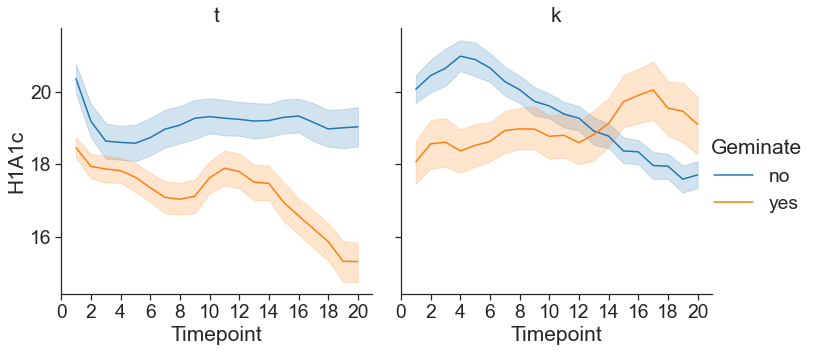

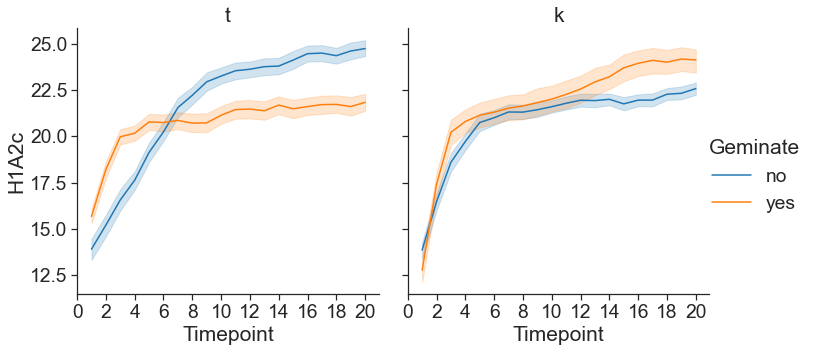

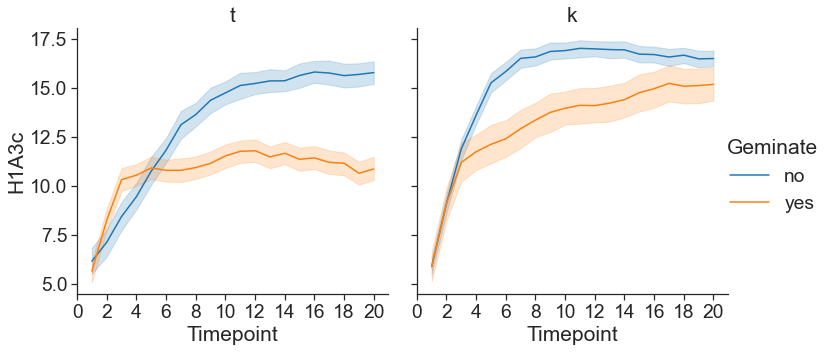

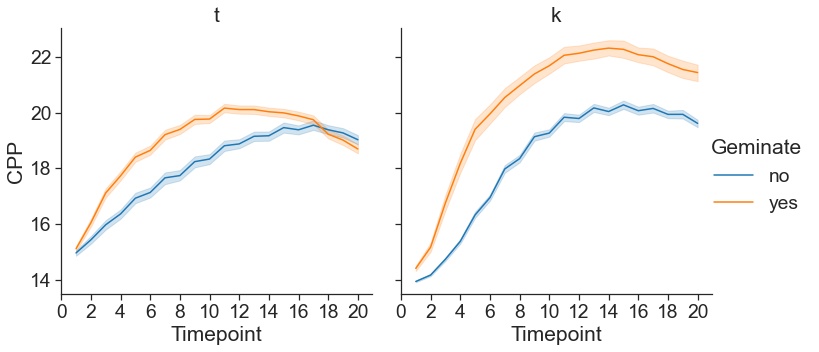

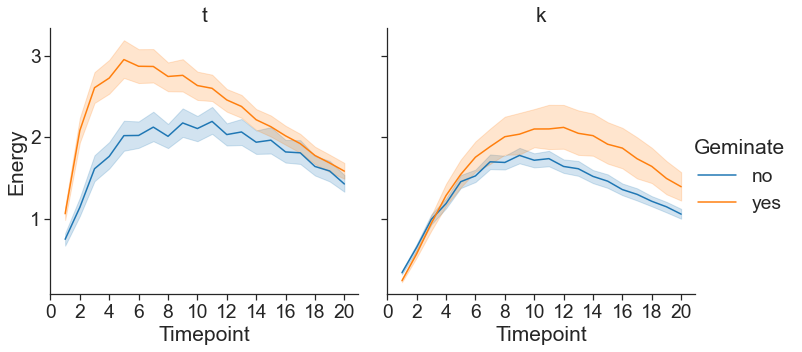

In [57]:
fac_to_title = {'strF0':'f0 (Hz)', 'pF1':'F1 (Hz)', 'pF2':'F2 (Hz)', 'H1H2c': 'H1* - H2* (dB)', 
                'H1A1c': 'H1* - A1* (dB)', 'H1A2c': 'H1* - A2* (dB)', 'H1A3c': 'H1* - A3* (dB)',
                'CPP': 'CPP (dB)', 'Energy': 'RMS Energy'}

for fac in fac_to_title.keys():

    g = sns.relplot(data = df_analyze_kt, x = 'time', y = fac, hue = 'geminate', kind = 'line', col = 'c_quality', col_order = ['t', 'k'])

    for ax, c in zip(g.axes.flat, ['t', 'k']):
    
        ax.set_xticks(np.arange(0, 21, 2))
        ax.set_xlabel('Timepoint')
        ax.set_title(c)
        
    plt.ylabel(fac_to_title[fac])

    g._legend.set_title('Geminate')

    plt.savefig('../visual/split/stop_' + fac + '.png', dpi = 300, facecolor = 'white')
    
    plt.close

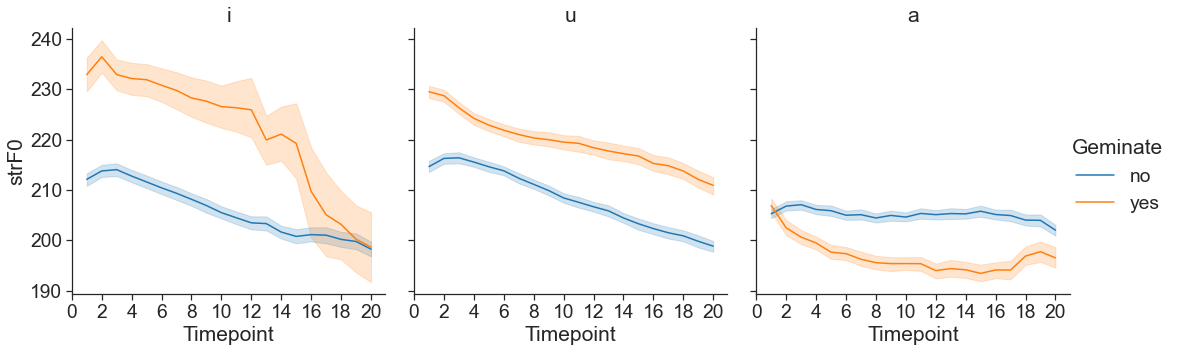

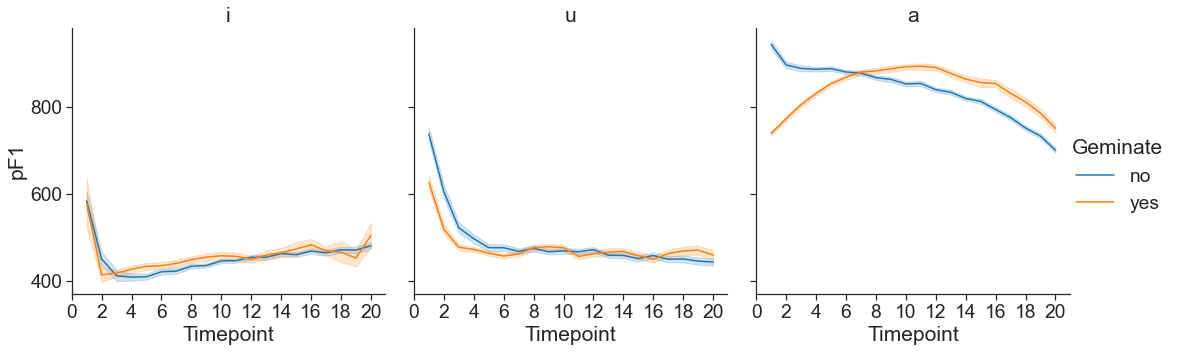

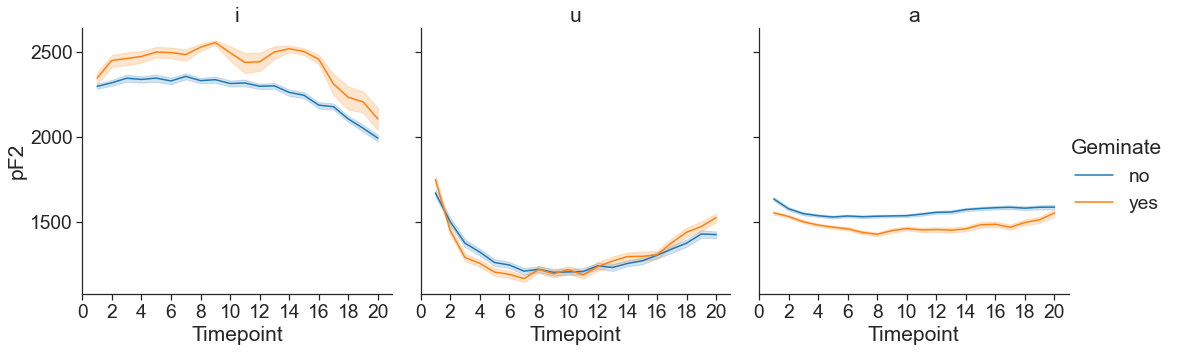

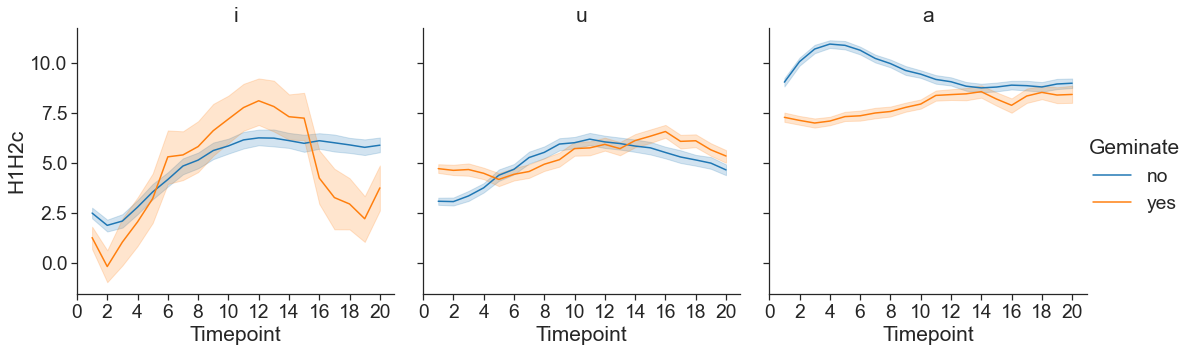

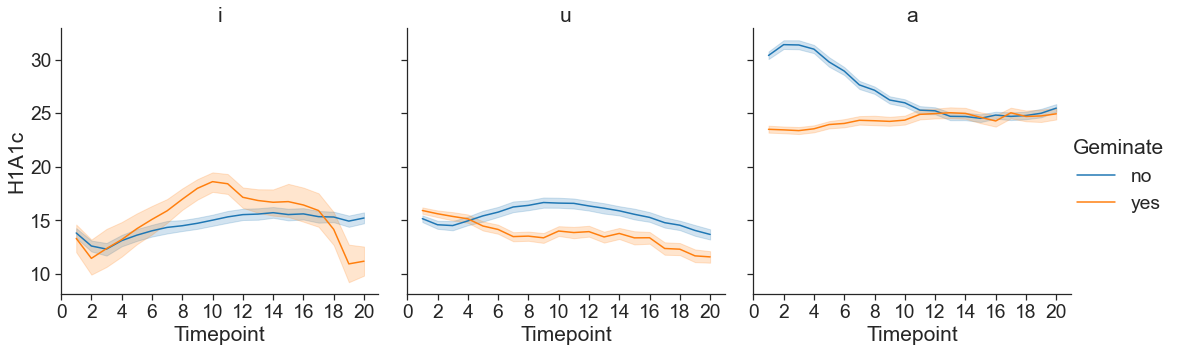

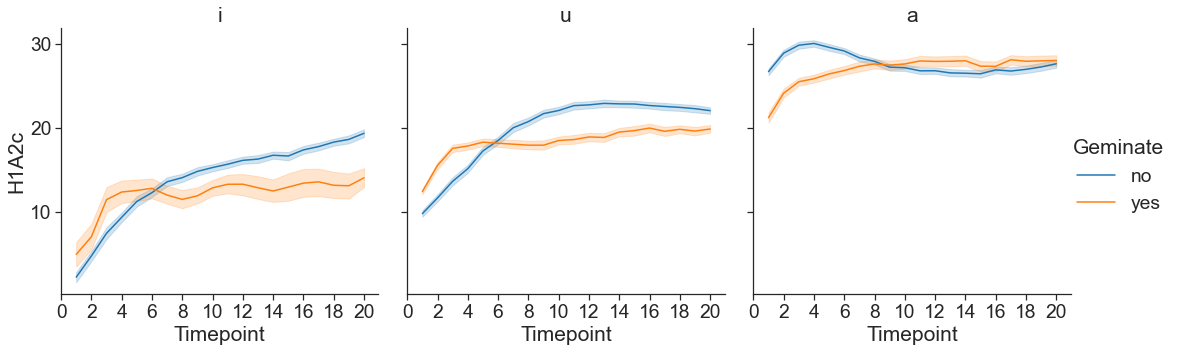

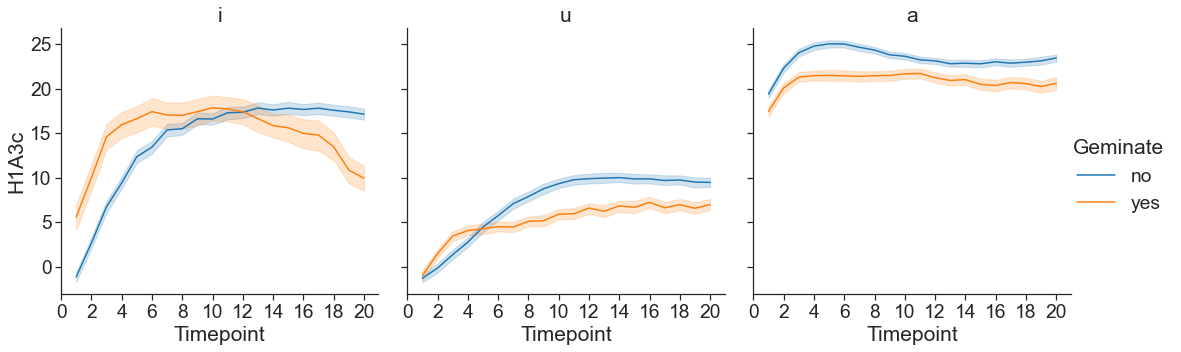

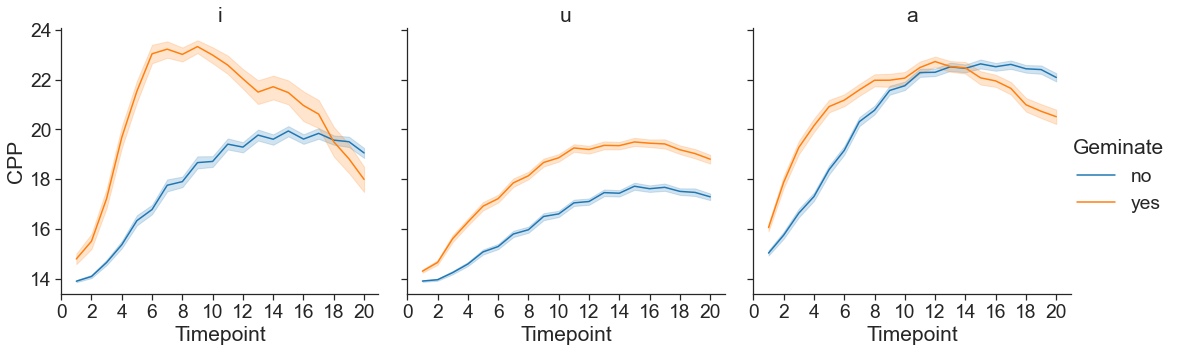

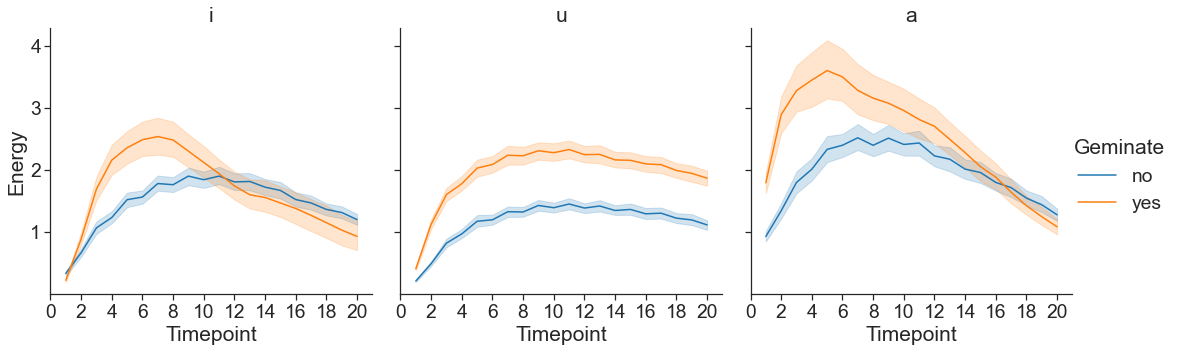

In [59]:
fac_to_title = {'strF0':'f0 (Hz)', 'pF1':'F1 (Hz)', 'pF2':'F2 (Hz)', 'H1H2c': 'H1* - H2* (dB)', 
                'H1A1c': 'H1* - A1* (dB)', 'H1A2c': 'H1* - A2* (dB)', 'H1A3c': 'H1* - A3* (dB)',
                'CPP': 'CPP (dB)', 'Energy': 'RMS Energy'}

for fac in fac_to_title.keys():

    g = sns.relplot(data = df_analyze_kt, x = 'time', y = fac, hue = 'geminate', kind = 'line', col = 'Label', col_order = ['i', 'u', 'a'])

    for ax, c in zip(g.axes.flat, ['i', 'u', 'a']):
    
        ax.set_xticks(np.arange(0, 21, 2))
        ax.set_xlabel('Timepoint')
        ax.set_title(c)
        
    plt.ylabel(fac_to_title[fac])

    g._legend.set_title('Geminate')

    plt.savefig('../visual/split/stop_' + fac + '.png', dpi = 300, facecolor = 'white')
    
    plt.close

# Nasal split up

In [64]:
fac_to_title = {'strF0':'f0 (Hz)', 'pF1':'F1 (Hz)', 'pF2':'F2 (Hz)', 'H1H2c': 'H1* - H2* (dB)', 
                'H1A1c': 'H1* - A1* (dB)', 'H1A2c': 'H1* - A2* (dB)', 'H1A3c': 'H1* - A3* (dB)',
                'CPP': 'CPP (dB)', 'Energy': 'RMS Energy'}

for fac in fac_to_title.keys():

    g = sns.relplot(data = df_analyze_nas, x = 'time', y = fac, hue = 'geminate', kind = 'line', col = 'c_quality', col_order = ['n', 'm'])

    for ax, c in zip(g.axes.flat, ['n', 'm']):
    
        ax.set_xticks(np.arange(0, 21, 2))
        ax.set_xlabel('Timepoint')
        ax.set_title(c)
        
    plt.ylabel(fac_to_title[fac])

    g._legend.set_title('Geminate')

    plt.savefig('../visual/split/nas_' + fac + '.png', dpi = 300, facecolor = 'white')
    
    plt.close()

# Correlations

In [65]:
burst_df = pd.read_csv('../data/stop_duration_nooutliers.csv')

# If can't detect burst, ignore
burst_df = burst_df.query('burst_time != -1')

burst_df['VOT'] = (burst_df['phon_end'] - burst_df['burst_time'])*1000
burst_df['closure_duration'] = (burst_df['burst_time'] - burst_df['new_start'])*1000

In [67]:
stop_means = df_analyze_kt.groupby(['Filename', 'seg_Start'])[[k for k in fac_to_title.keys()]].mean().reset_index()

burst_df['Filename'] = burst_df['fname'].apply(lambda f: f.replace('/aligned/', '\\').replace('TextGrid', 'mat'))

# Change time to seconds
burst_df['seg_Start'] = burst_df['next_phon_start'] * 1000

burst_means = burst_df.merge(stop_means, on = ['Filename', 'seg_Start'])

Geminate closure duration and strF0 correlation: (-0.22119870466040695, 0.0002771283025907559)
Singleton closure duration and strF0 correlation: (0.05801607056651063, 0.12221222390498457)


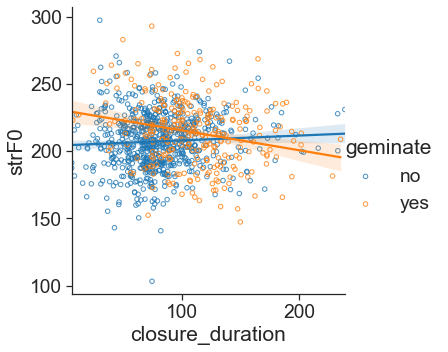

In [69]:
x = 'closure_duration'
m = 'strF0'

sns.lmplot(data = burst_means.query('c_quality in ["k", "t"]'), x = x, y = m, hue = 'geminate', scatter_kws = {"s":20, "facecolors":"none"})#, col = 'c_quality')

print('Geminate closure duration and', m, 'correlation:', pearsonr(burst_means.query("(c_quality in ['k', 't']) & (geminate == 'yes')")[x], 
                                                                 burst_means.query("(c_quality in ['k', 't']) & (geminate == 'yes')")[m]))
print('Singleton closure duration and', m, 'correlation:', pearsonr(burst_means.query("(c_quality in ['k', 't']) & (geminate == 'no')")[x], 
                                                                 burst_means.query("(c_quality in ['k', 't']) & (geminate == 'no')")[m]))

In [72]:
nasal_means = df_analyze_nas.groupby(['Filename', 'seg_Start'])[[k for k in fac_to_title.keys()]].mean().reset_index()

nasal_mean_analyze = df_nas_info.merge(nasal_means, on = ['Filename', 'seg_Start'])

In [74]:
def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = pearsonr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    return p_matrix

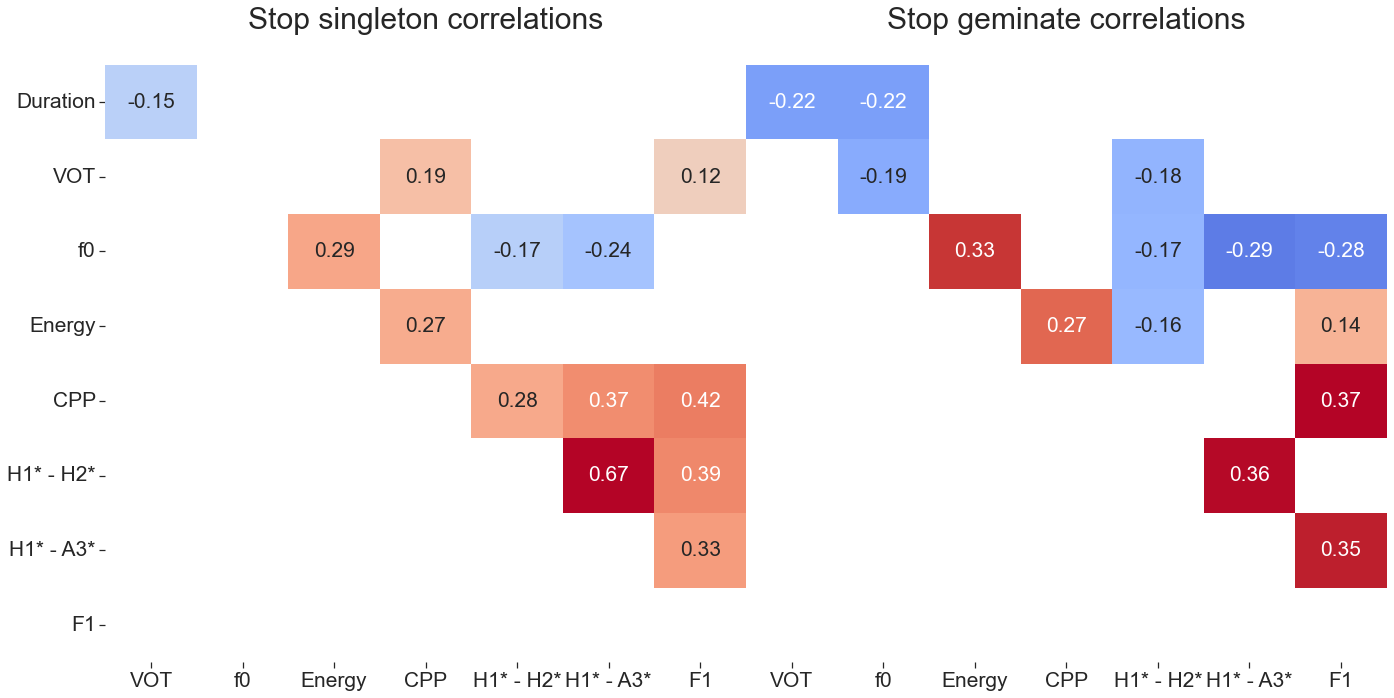

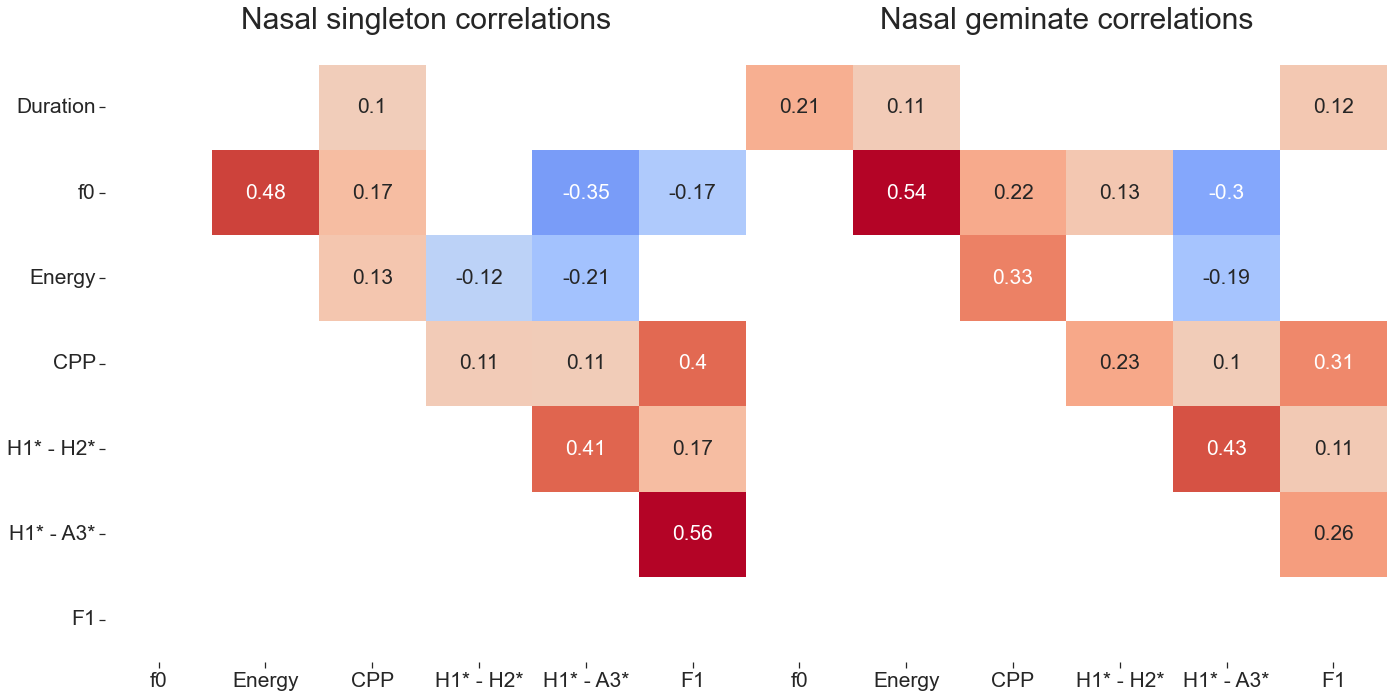

In [75]:
import itertools

for df in [burst_means, nasal_mean_analyze]:

    sub = ['closure_duration', 'VOT', 'strF0', 'Energy', 'CPP', 'H1H2c', 'H1A3c', 'pF1'] if df.equals(burst_means) else ['duration', 'strF0', 'Energy', 'CPP', 'H1H2c', 'H1A3c', 'pF1']
    
    fig, axs = plt.subplots(1, 2, figsize = (20, 10))
    
    for i, gem in enumerate(['no', 'yes']):
    
        ax = axs.flat[i]
    
        corr_df = df.query('geminate == @gem')[sub]

        corr_df = corr_df.rename(columns = {'closure_duration':'Duration', 'duration':'Duration', 'strF0': 'f0', 'H1H2c':'H1* - H2*', 'H1A3c':'H1* - A3*', 'pF1':'F1'})

        corr = corr_df.corr()

        p_values = corr_sig(corr_df)

        # Generate a mask for the upper triangle
        mask = np.invert(np.triu((p_values < 0.05) & (abs(corr) > .1)))#np.ones_like(corr, dtype=bool))

        np.fill_diagonal(mask, 1)
        
        sns.heatmap(corr.drop(columns = 'Duration'), mask = mask[:,1:], cmap = 'coolwarm', 
                    center = 0, annot=True, cbar = False, ax = ax)

        xlabels = [item.get_text() for item in ax.get_xticklabels()]
        ylabels = [item.get_text() for item in ax.get_yticklabels()]
        
        title = 'Stop ' if df.equals(burst_means) else 'Nasal ' 
        
        if i == 0:
            ax.set_yticklabels(ylabels, va = 'center', rotation = 0, fontdict = {'fontsize': 21})
            title += 'singleton correlations'
        else: 
            ax.set_yticks([])
            title += 'geminate correlations'
        
        ax.set_xticklabels(xlabels, rotation = 0, fontdict = {'fontsize': 21})
        ax.set_title(title, fontdict = {'fontsize': 30}, y = 1.05)

    plt.subplots_adjust(left = 0.08, right = 0.97, bottom = 0.05, wspace = 0)
    
    write_obs = 'stop' if df.equals(burst_means) else 'nas'
    
    plt.savefig('../visual/poster/' + write_obs + '-corr.png', dpi = 300, transparent = True)
    
    plt.show()